In [1]:
import pandas as pd
import sklearn as skit
import matplotlib.pyplot as plt
! pip install mglearn
import mglearn
import seaborn as sns
import numpy as np

In [2]:
pd.set_option('max_columns',10)
pd.set_option('max_rows',50)


In [3]:
tw = pd.DataFrame(pd.read_csv('/content/drive/MyDrive/Studium/3. Semester/Fallstudie/twitter_and_stockdata_cleaned_final.csv'))
tw = tw.drop(columns=['Unnamed: 0','Unnamed: 0.1','username', 'id', 'text', 'Score'])


In [4]:
print(tw.head(10))
print(tw.tail(10))

         date  retweet  likes  \
0  2020-12-29        0      1   
1  2020-12-29        0      1   
2  2020-12-28        7     38   
3  2020-12-28        0      1   
4  2020-12-23        2     27   
5  2020-12-23        0      1   
6  2020-12-22        0      1   
7  2020-12-22        5     47   
8  2020-12-22        0      1   
9  2020-12-22        1      7   

                                              Symbol  Subjectivity  Polarity  \
0                                  ['AAPL', 'GOOGL']      0.430556  0.022222   
1            ['AAPL', 'MSFT', 'TSM', 'ADBE', 'QCOM']      0.616667  0.466667   
2  ['AAPL', 'AMZN', 'GOOGL', 'MSFT', 'FB', 'V', '...      0.553737 -0.134545   
3            ['TSLA', 'BABA', 'AAPL', 'TSM', 'MSFT']      0.500000  0.280000   
4  ['AMD', 'QRVO', 'TSM', 'LRCX', 'MPWR', 'AAPL',...      0.283333 -0.033333   
5                                           ['FUBO']      0.326667  0.150000   
6                                           ['FUBO']      0.340000  0.070000

In [5]:
print("Keys of tw dataset:\n", tw.keys())
print("Shape of data:", tw.shape)
print(tw.dtypes)

Keys of tw dataset:
 Index(['date', 'retweet', 'likes', 'Symbol', 'Subjectivity', 'Polarity',
       'Growth_one_day'],
      dtype='object')
Shape of data: (1174, 7)
date               object
retweet             int64
likes               int64
Symbol             object
Subjectivity      float64
Polarity          float64
Growth_one_day     object
dtype: object


In [6]:
stocks = pd.DataFrame(pd.read_csv('/content/drive/MyDrive/Studium/3. Semester/Fallstudie/dataaktien_clean_list.csv'))
stocks = stocks.drop(columns=['Unnamed: 0', 'Full_name'])

In [7]:
print(stocks.head(10))
print(stocks.tail(10))

  Ticker
0   AACG
1   AACQ
2  AACQU
3  AACQW
4    AAL
5   AAME
6   AAOI
7   AAON
8   AAPL
9   AAWW
     Ticker
3477     ZM
3478   ZNGA
3479  ZNTEU
3480   ZNTL
3481     ZS
3482   ZSAN
3483   ZUMZ
3484    ZVO
3485  ZVZZC
3486   ZYXI


In [8]:
print("Keys of stocks dataset:\n", stocks.keys())
print("Shape of stocks:", stocks.shape)

Keys of stocks dataset:
 Index(['Ticker'], dtype='object')
Shape of stocks: (3487, 1)


In [9]:
def clean_alt_list(list_):
    list_ = list_.replace(', ', '","')
    list_ = list_.replace('[', '["')
    list_ = list_.replace(']', '"]')
    return list_

In [10]:
def get_df(ticker):
    df = tw
    df["Symbol"] = df["Symbol"].apply(eval)

    #df['Growth_one_day'] = df['Growth_one_day'].apply(clean_alt_list)
    df['Growth_one_day'] = df['Growth_one_day'].apply(eval)

    for i in range(len(df)):
        symbol_list = df['Symbol'][i]
        growth_list = df['Growth_one_day'][i]
        #print(type(df['Symbol'][i]))
        #print(type(df['Growth_one_day'][i]))
        if (ticker in symbol_list):
            df.at[i, 'Symbol'] = ticker
            index = symbol_list.index(ticker)
            growth = growth_list[index]
            df.at[i, 'Growth_one_day'] = float(growth)
        else:
            df.at[i, 'Symbol'] = ''
            df.at[i,'Growth_one_day'] = ''
    df = df.drop(df[df.Symbol == ''].index)
    aggregate_functions = {'retweet': 'sum', 'likes':'sum', 'Symbol':'first', 'Subjectivity': 'mean', 'Polarity': 'mean', 'Growth_one_day': 'first'}
    df = df.groupby(df['date']).aggregate(aggregate_functions)
    df.loc[df['Growth_one_day'] > 0, 'Growth_one_day'] = 1
    df.loc[df['Growth_one_day'] < 0, 'Growth_one_day'] = -1
    #print(df)
    return df

In [11]:
df = get_df('TSLA')

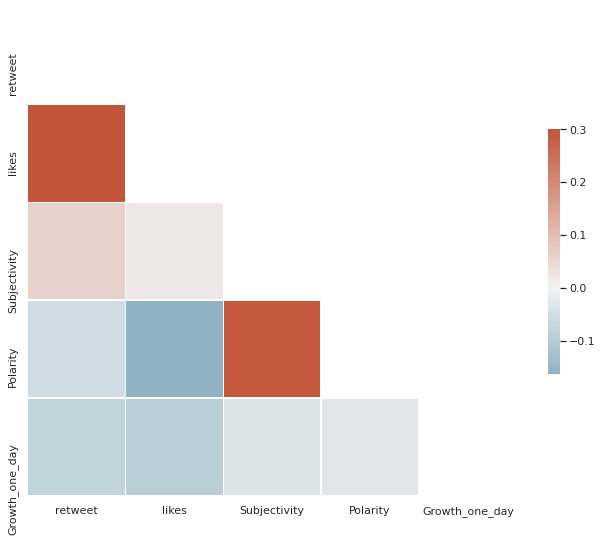

In [12]:
sns.set_theme(style="white")
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [13]:
import numpy as np

Y = np.asarray(df['Growth_one_day'])
X = np.asarray(df[['retweet', 'likes', 'Subjectivity', 'Polarity']])


In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, shuffle= True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fef9cf26d30>,
      dtype=object)

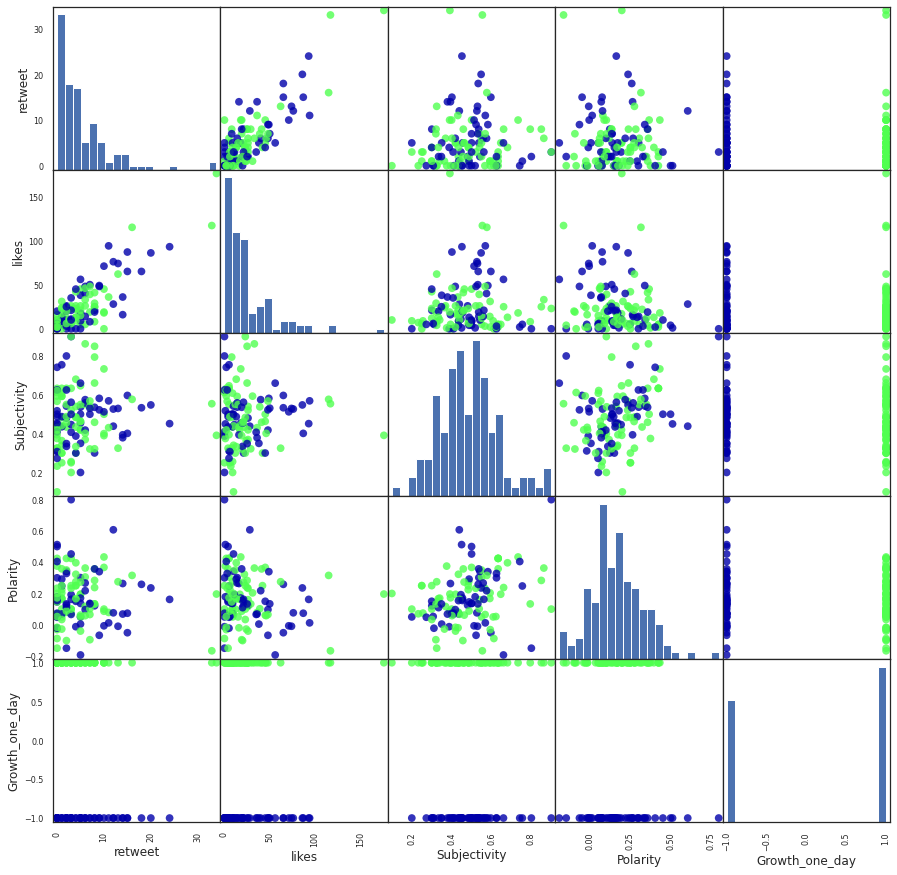

In [15]:
# create a scatter matrix from the dataframe, color by y_train
pd.plotting.scatter_matrix(df, figsize=(15, 15), c=Y,
                           marker='o', hist_kwds={'bins': 20}, s=60,
                           alpha=.8, cmap=mglearn.cm3)

In [16]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.531
